<a href="https://colab.research.google.com/github/kidstyle777/trial/blob/master/Thin_Plate_Spline_Motion_Model_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title #**1.セットアップ**

# githubからコードをコピー
! git clone https://github.com/cedro3/Thin-Plate-Spline-Motion-Model.git
%cd Thin-Plate-Spline-Motion-Model

# チェックポイントのダウンロード
!mkdir checkpoints
!wget -c https://cloud.tsinghua.edu.cn/f/da8d61d012014b12a9e4/?dl=1 -O checkpoints/vox.pth.tar
#!wget -c https://cloud.tsinghua.edu.cn/f/483ef53650b14ac7ae70/?dl=1 -O checkpoints/ted.pth.tar
#!wget -c https://cloud.tsinghua.edu.cn/f/9ec01fa4aaef423c8c02/?dl=1 -O checkpoints/taichi.pth.tar
#!wget -c https://cloud.tsinghua.edu.cn/f/cd411b334a2e49cdb1e2/?dl=1 -O checkpoints/mgif.pth.tar

# ランドマークデータのダウンロード
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

# 関数のインポート
from function import *

# downloadフォルダ作成
import os
os.makedirs('examples/download')


Cloning into 'Thin-Plate-Spline-Motion-Model'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 134 (delta 44), reused 131 (delta 43), pack-reused 0
Receiving objects: 100% (134/134), 35.31 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/Thin-Plate-Spline-Motion-Model
--2022-07-20 06:49:52--  https://cloud.tsinghua.edu.cn/f/da8d61d012014b12a9e4/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 166.111.6.101, 2402:f000:1:406:166:111:6:101
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|166.111.6.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/b1c0709b-5a66-4c4c-8d5d-580bc148af48/vox.pth.tar [following]
--2022-07-20 06:49:53--  https://cloud.tsinghua.edu.cn/seafhttp/files/b1c0709b-5a66-4c4c-8d5d-580bc148af48/vox.pth.tar
Reusing existing connection to cloud.

=== source ===


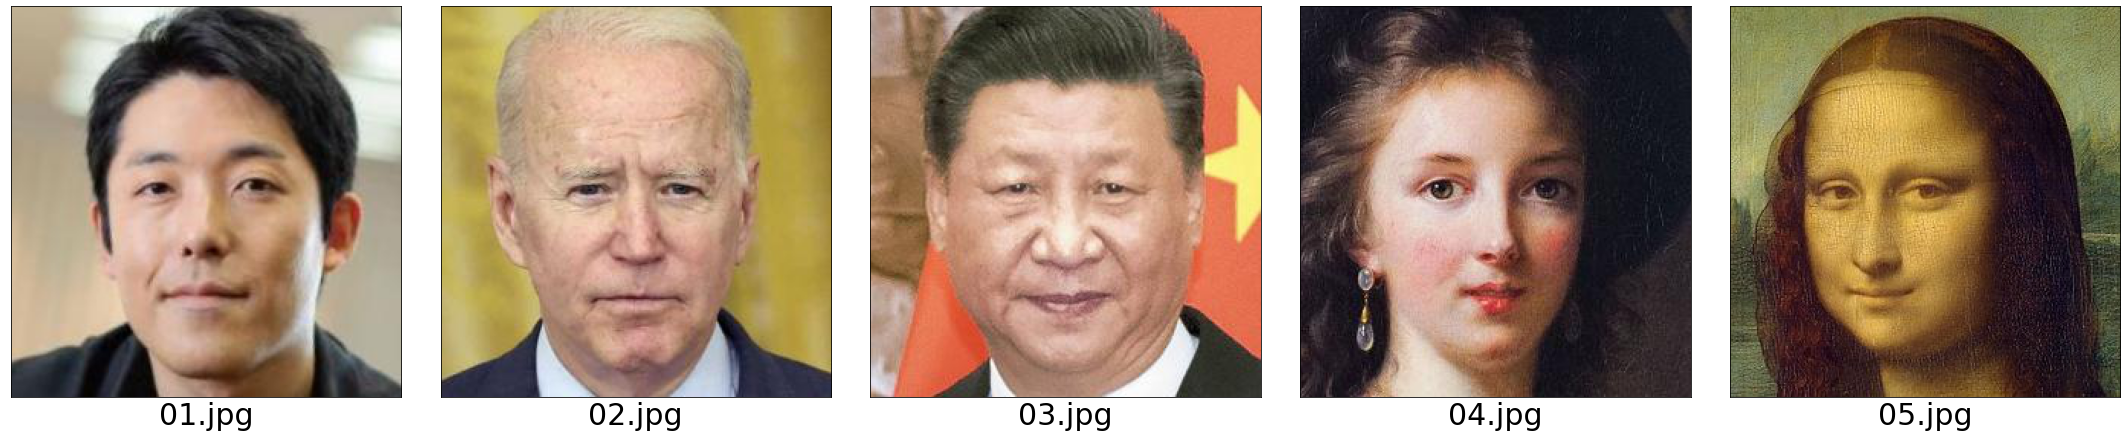

=== video ===


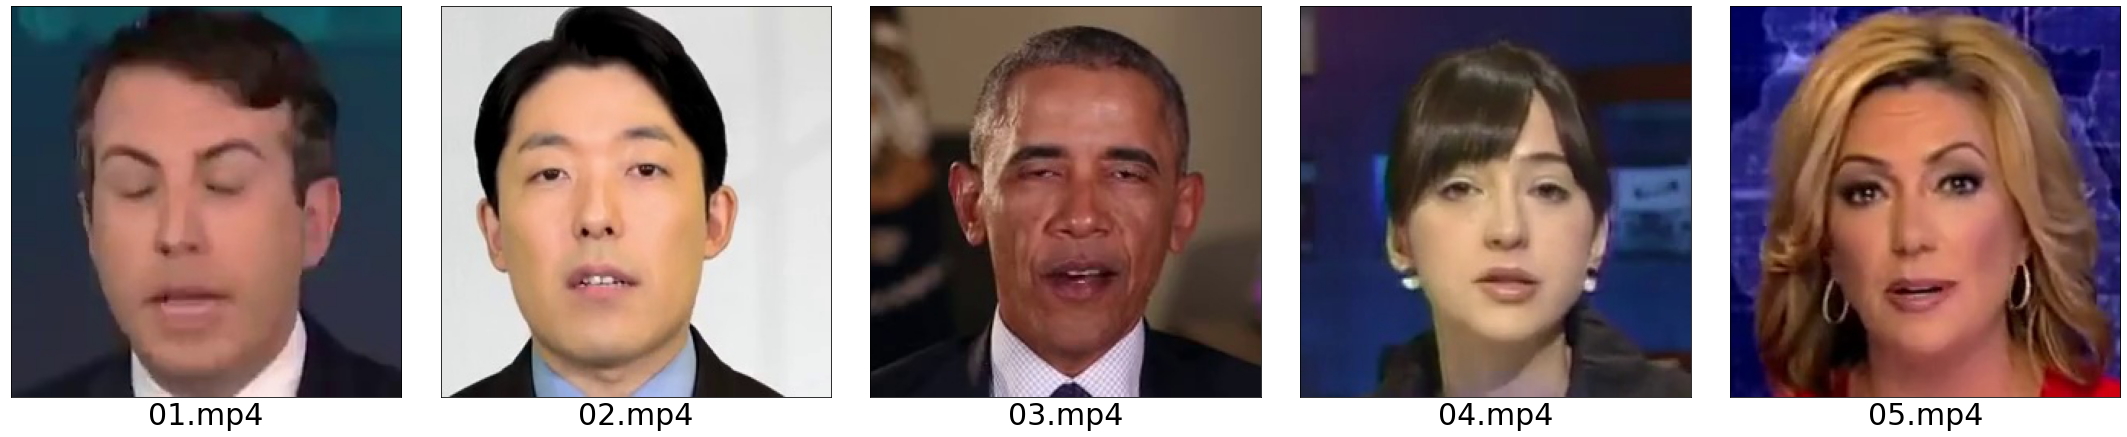

In [ ]:
#@title #**2.ソースとビデオの表示**

%matplotlib inline

# --- 画像表示 ---
print('=== source ===')
display_pic('examples/source')

# --- 動画表示 ---
print('=== video ===')
reset_folder('examples/pic_video')
import glob
files = sorted(glob.glob('examples/video/*.mp4'))
names = []
for file in files:
  name = os.path.basename(file)
  save_frame(name, 'examples/video', 'examples/pic_video')
  names.append(name)
display_movie('examples/pic_video', names)

In [ ]:
#@title #**3.動画の作成**

import imageio
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML, clear_output
import warnings
import os

warnings.filterwarnings("ignore")

# ソースとビデオのファイル名
source = '03.jpg' #@param {"type": "string"}
video = '04.mp4' #@param {"type": "string"} 

# 設定
import torch
device = torch.device('cuda:0')
dataset_name = 'vox' # ['vox', 'taichi', 'ted', 'mgif']
source_image_path = './examples/source/'+source
driving_video_path = './examples/video/'+video
output_video_path = './generated.mp4'
config_path = 'config/vox-256.yaml'
checkpoint_path = 'checkpoints/vox.pth.tar'
predict_mode = 'relative' # ['standard', 'relative', 'avd']
find_best_frame = False # when use the relative mode to animate a face, use 'find_best_frame=True' can get better quality result

pixel = 256 # for vox, taichi and mgif, the resolution is 256*256
if(dataset_name == 'ted'): # for ted, the resolution is 384*384
    pixel = 384

if find_best_frame:
  !pip install face_alignment

# モデルのロード
from demo import load_checkpoints
inpainting, kp_detector, dense_motion_network, avd_network = load_checkpoints(config_path = config_path, checkpoint_path = checkpoint_path, device = device)


# ソースの読み込み
source_image = imageio.imread(source_image_path)
source_image = resize(source_image, (pixel, pixel))[..., :3]


# ビデオの読み込み
reader = imageio.get_reader(driving_video_path)
fps = reader.get_meta_data()['fps']
print('fps = ', fps) ####
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()
driving_video = [resize(frame, (pixel, pixel))[..., :3] for frame in driving_video]


# 予測
from demo import make_animation
from skimage import img_as_ubyte

if predict_mode=='relative' and find_best_frame:
    from demo import find_best_frame as _find
    i = _find(source_image, driving_video, device.type=='cpu')
    print ("Best frame: " + str(i))
    driving_forward = driving_video[i:]
    driving_backward = driving_video[:(i+1)][::-1]
    predictions_forward = make_animation(source_image, driving_forward, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)
    predictions_backward = make_animation(source_image, driving_backward, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)
    predictions = predictions_backward[::-1] + predictions_forward[1:]
else:
    predictions = make_animation(source_image, driving_video, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)


# 画像の連結
import cv2
import numpy as np

reset_folder('images')
reset_folder('images2')

for i in range(len(predictions)):
    source_img = (source_image * 255).astype(np.uint8)
    drive = (driving_video[i] * 255).astype(np.uint8)
    predict = (predictions[i] * 255).astype(np.uint8)

    # 横長
    tmp = cv2.hconcat([source_img, drive])
    img = cv2.hconcat([tmp, predict])
    imageio.imwrite('images/'+str(i).zfill(6)+'.jpg', img)

    # スクエア
    black = cv2.imread('black.jpg')
    up = cv2.hconcat([black, source_img])
    down = cv2.hconcat([drive, predict])
    all = cv2.vconcat([up, down])
    imageio.imwrite('images2/'+str(i).zfill(6)+'.jpg', all)

# 動画作成
print('making movie...')
! ffmpeg -y -r $fps -i images/%06d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error out.mp4
! ffmpeg -y -r $fps -i images2/%06d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error out2.mp4

# 音声抽出・付加
print('preparation for sound...')
! ffmpeg -y -i $driving_video_path -loglevel error sound.mp3
! ffmpeg -y -i out.mp4 -i sound.mp3 -loglevel error output.mp4
! ffmpeg -y -i out2.mp4 -i sound.mp3 -loglevel error output2.mp4

# 画像の再生
clear_output()
display_mp4('output.mp4')


In [ ]:
#@title #**4.動画のダウンロード**

#@markdown ・正方形にしたい場合は、squareにチェックを入れて下さい

import shutil
source_name = os.path.splitext(source)
video_name = os.path.splitext(video)

square = True #@param {type:"boolean"}

if square == True:
  download_name = 'examples/download/'+source_name[0]+'_'+video_name[0]+'s.mp4'
  shutil.copy('output2.mp4', download_name)
else:
  download_name = 'examples/download/'+source_name[0]+'_'+video_name[0]+'b.mp4'
  shutil.copy('output.mp4', download_name)

from google.colab import files
files.download(download_name)

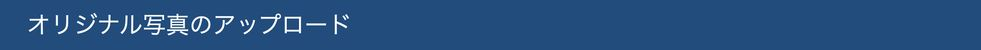

In [ ]:
#@title #**5.画像のアップロード**

# ルートへ画像をアップロード
from google.colab import files
reset_folder('pic')
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, 'pic')

%matplotlib inline
display_pic('pic')


NameError: ignored

In [ ]:
#@title #**6.顔の切り出し**
import os
import shutil
from tqdm import tqdm
import glob

reset_folder('align')

def run_alignment(image_path):
  import dlib
  from alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  return aligned_image 
 
files = sorted(glob.glob('pic/*.jpg'))
for i, file in enumerate(tqdm(files)):
  input_image = run_alignment(file)
  input_image.resize((1024,1024))
  name = os.path.basename(file)
  input_image.save('./align/'+name)

%matplotlib inline 
display_pic('align')

In [ ]:
#@title #**7.ソースへ追加**
add = '' #@param {type:"string"}

import shutil
shutil.copy('align/'+add, 'examples/source/'+add)

